######  Apache Spark™ is a unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. On Single Machine , Spark can have lower memory consumption and can process more data than laptop ’s memory size, as it does not require loading the entire data set into memory before processing

#### Intialize context to interact with Spark Cluster

In [1]:
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder \
...     .master("local") \
...     .appName("Word Count") \
...     .getOrCreate()

In [4]:
spark.version

'2.4.3'

### Read Log file and Perform Preprocessing

In [5]:
log_file_path = r'D:\jupyter bootcamp\clonedrepo\notebooks\testdata\apache_logs\apache.access.log.PROJECT_2.txt'

In [6]:
base_df = spark.read.text(log_file_path)

In [7]:
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [8]:
base_df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------------------------+
|reports.arc.nasa.gov - - [09/Aug/1995:13:23:23 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1713                              |
|atl57298.bwi.wec.com - - [09/Aug/1995:13:23:24 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-launch-3.mpg HTTP/1.0" 200 130724|
|cat.dbs.ucdavis.edu - - [09/Aug/1995:13:23:24 -0400] "GET /shuttle/missions/sts-70/mission-sts-70.html HTTP/1.0" 200 20113         |
|gorgax06.pixi.com - - [09/Aug/1995:13:23:24 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 200 234                                |
|russell.dp.ox.ac.uk - - [09/Aug/1995:13:23:24 -0400] "GET /hi

In [9]:
base_df.describe()

DataFrame[summary: string, value: string]

In [10]:
base_df.count()

350296

In [11]:
from pyspark.sql.functions import split, regexp_extract
split_df = base_df.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size'))
split_df.show(truncate=False)

+------------------------+--------------------------+---------------------------------------------------+------+------------+
|host                    |timestamp                 |path                                               |status|content_size|
+------------------------+--------------------------+---------------------------------------------------+------+------------+
|reports.arc.nasa.gov    |09/Aug/1995:13:23:23 -0400|/images/launch-logo.gif                            |200   |1713        |
|atl57298.bwi.wec.com    |09/Aug/1995:13:23:24 -0400|/shuttle/missions/sts-71/movies/sts-71-launch-3.mpg|200   |130724      |
|cat.dbs.ucdavis.edu     |09/Aug/1995:13:23:24 -0400|/shuttle/missions/sts-70/mission-sts-70.html       |200   |20113       |
|gorgax06.pixi.com       |09/Aug/1995:13:23:24 -0400|/images/USA-logosmall.gif                          |200   |234         |
|russell.dp.ox.ac.uk     |09/Aug/1995:13:23:24 -0400|/history/apollo/apollo-13/apollo-13.html           |200   |18556 

In [12]:
#check  if new df has any null values
from pyspark.sql.functions import col, sum

def count_null(col_name):
  return sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
#
# This could be done in one line with a Python list comprehension, but we're keeping
# it simple for those who don't know Python very well.
exprs = []
for col_name in split_df.columns:
  exprs.append(count_null(col_name))

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
split_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|        2677|
+----+---------+----+------+------------+



In [13]:
## fill all null values with 0
cleaned_df = split_df.na.fill({'content_size': 0})

In [14]:
# Ensure that there are no nulls left.
exprs = []
for col_name in cleaned_df.columns:
      exprs.append(count_null(col_name))

cleaned_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|           0|
+----+---------+----+------+------------+



In [15]:
## Handle Timestamp in dataframe
from datetime import datetime as dt
converted= dt.strptime("09/Aug/1995:13:23:23 -0400", "%d/%b/%Y:%H:%M:%S %z")


In [16]:
converted

datetime.datetime(1995, 8, 9, 13, 23, 23, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))

from pyspark.sql.functions import udf
from datetime import datetime as dt

def parse_clf_time(s):
    return dt.strptime(s, "%d/%b/%Y:%H:%M:%S %z")

u_parse_time = udf(parse_clf_time)

logs_df = cleaned_df.select('*', u_parse_time(split_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
total_log_entries = logs_df.count()

In [17]:
from pyspark.sql.functions import udf
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(s):
    """ Convert Common Log time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring time zone here. In a production application, you'd want to handle that.
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(s[7:11]),
      month_map[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20])
    )

u_parse_time = udf(parse_clf_time)

logs_df = cleaned_df.select('*', u_parse_time(split_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
total_log_entries = logs_df.count()

In [18]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [19]:
total_log_entries

350296

In [20]:
### keep the dataframe in cache for increasing speed
logs_df.cache()

DataFrame[host: string, path: string, status: int, content_size: int, time: timestamp]

In [21]:
# Calculate statistics based on the content size.
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+-----------------+
|summary|     content_size|
+-------+-----------------+
|  count|           350296|
|   mean|17778.18860620732|
| stddev| 70095.7214882202|
|    min|                0|
|    max|          3155499|
+-------+-----------------+



In [22]:
status_to_count_df =(logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [23]:
status_to_count_length = status_to_count_df.count()
print('Found %d response codes' % status_to_count_length)
status_to_count_df.show()

Found 6 response codes
+------+------+
|status| count|
+------+------+
|   200|315078|
|   302|  5759|
|   304| 27650|
|   403|    23|
|   404|  1781|
|   501|     5|
+------+------+



In [25]:
from spark_notebook_helpers import prepareSubplot, np, plt, cm

In [26]:
help(prepareSubplot)

Help on function prepareSubplot in module spark_notebook_helpers:

prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999', gridWidth=1.0, subplots=(1, 1))
    Template for generating the plot layout.



In [29]:
from pyspark.sql import functions as sqlFunctions
log_status_to_count_df = status_to_count_df.withColumn('log(count)', sqlFunctions.log(status_to_count_df['count']))

display(log_status_to_count_df)

DataFrame[status: int, count: bigint, log(count): double]

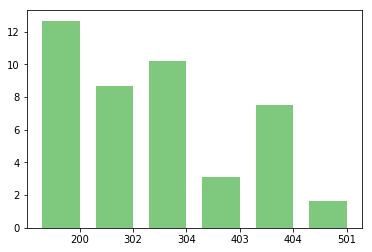

In [32]:
data = log_status_to_count_df.drop('count').collect()
x, y = zip(*data)
index = np.arange(len(x))
bar_width = 0.7
colorMap = 'Accent'
cmap = cm.get_cmap(colorMap)
plt.bar(index, y, width=bar_width, color=cmap(0))
plt.xticks(index + bar_width/2.0, x)
plt.show()

In [33]:
# Any hosts that has accessed the server more than 10 times.
host_sum_df =(logs_df
              .groupBy('host')
              .count())

host_more_than_10_df = (host_sum_df
                        .filter(host_sum_df['count'] > 10)
                        .select(host_sum_df['host']))

print('Any 20 hosts that have accessed more then 10 times:\n')
host_more_than_10_df.show(truncate=False)

Any 20 hosts that have accessed more then 10 times:

+-----------------------------+
|host                         |
+-----------------------------+
|192.86.21.180                |
|prufrock.gsfc.nasa.gov       |
|n1377004.ksc.nasa.gov        |
|137.49.30.66                 |
|204.50.118.17                |
|skfoley_pc.orem.novell.com   |
|pm2-22.magicnet.net          |
|ns1.ix.net                   |
|dd03-023.compuserve.com      |
|steelwil.dh.i-2000.com       |
|winnie.freenet.mb.ca         |
|166.99.15.250                |
|ecepc47.ece.jcu.edu.au       |
|cavy.info.lv                 |
|wildcard.amat.com            |
|milton.hps                   |
|hpb.hwc.ca                   |
|163.205.2.134                |
|129.53.154.180               |
|vansciver6mac.magnet.fsu.edu |
+-----------------------------+
only showing top 20 rows



### Plot location of 1000 hosts

In [131]:
import geoip2.database

In [132]:
reader=geoip2.database.Reader('GeoLite2-City.mmdb')

In [85]:
df1=logs_df.toPandas()

In [86]:
hostlist=list(df1['host'])

In [133]:
longitudelist=[]
latitudelist=[]
for host in hostlist:
    if host[-2:-1].isnumeric():
        host=host[:-1]#check if it is IP address
        try:
            response=reader.city(host)
            if response.location.latitude!=None:
                longitudelist.append(response.location.longitude)
                latitudelist.append(response.location.latitude)
        except:
            pass
reader.close()

In [134]:
len(longitudelist)

149724

In [142]:
import pandas as pd
import folium

In [143]:
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)


In [149]:
for i in range(4000,5000):
    folium.Marker([longitudelist[i],latitudelist[i]]).add_to(m)


In [150]:
m

In [151]:
m.save('map_1000.html')